# NLP on PRR: Visualization and Interaction

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from wordcloud import WordCloud
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Word Cloud

In [135]:
# load the corresponding dataset
words = pd.read_csv('viz-data/wordcloud-master-data.csv')
words = words[words.dept == 'ART']

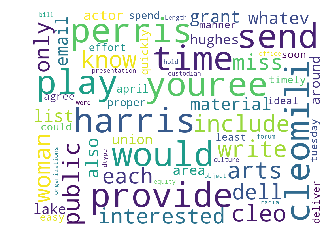

In [136]:
FILTER_WORDS = ['record', 'name', 'datum', 'seattle']

wordcloud = WordCloud(background_color='white',
                      width=1024,
                      stopwords=FILTER_WORDS,
                      height=768,
                      max_words=200,
                      max_font_size=120,
                      random_state=42
                     ).generate(str(words['word']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Topics Over Time

This section consists of visualizations of the most salient topics over time. These topics were gathered through a combination of statistical analyses with design thinking processes, as outlined in the notebook "NLP on PRR". Check it out for some theoretical information on latent dirichlet allocation (LDA), and some process-based stuff related to how we named the topics.

In [255]:
# @hidden_cell
# load the corresponding datasets
topics = pd.read_csv('viz-data/topics-over-time-data.csv',
                     index_col=['Unnamed: 0']).sort_index()

words_over_time = pd.read_csv('viz-data/test-export-data.csv',
                     index_col=['create_date']).sort_index().drop(['Unnamed: 0'], axis=1)

def filter_dfs(df, string):
    cols = [i for i in df.columns if not i.find(string) ]
    return [ df[i] for i in cols ], cols

def count_keywords(df, col, topic):
    # ARGUMENTS: df; a dataframe
    # col; a column of the dataframe
    # topic; a list of lists, containing strings
    # OUTPUTS: data; a dataframe
    #
    # this function counts the mentions of a word
    #
    # generate an empty dataframe
    data = pd.DataFrame()
    # for each list of strings
    for i in topic:
        # subset the dataframe, and determine whether
        # a string is in a row. if it is, then return
        # True, otherwise false
        mask = df[col].str.contains(i)
        # subset the dataframe by values > 0 (i.e. True values)
        mask = mask[mask > 0]
        # reset the index and drop the indicies that are duplicates
        #
        # this ensures entries aren’t double-counted if they contain multiple words
        # related to a topic. it only gets the first entry in the topic category
        mask = mask.reset_index().drop_duplicates(subset='create_date', keep='first')
        # add the data to the dataframe
        data = data.append(mask)
    data = data.groupby('create_date').count().reset_index()
    data['create_date'] = data['create_date'].astype(str).str[0:7]
    data = data.groupby('create_date').sum()
    return data.sort_index()

def bokeh_plot(list_of_dfs):
    # if you know what you are doing, don't be afraid to change the
    # parameters for size etc.
    p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
    p.title.text = 'Click on legend entries to hide the corresponding lines'

    for data, name, color in zip(list_of_dfs[0], list_of_dfs[1], Spectral4):
        df = pd.DataFrame(data)
        df = df.reset_index()
        df['index'] = pd.to_datetime(df['index'])
        p.line(df['index'], df[name], 
               line_width=2, color=color, alpha=0.8, legend=name)

    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    show(p)

In [222]:
everything = filter_dfs(topics, 'ALL:')
bokeh_plot(everything)

In [176]:
everything = filter_dfs(topics, 'SEA:')
bokeh_plot(everything)

In [177]:
everything = filter_dfs(topics, 'POR:')
bokeh_plot(everything)

In [178]:
everything = filter_dfs(topics, 'OLY:')
bokeh_plot(everything)

## Now you try!

If you would like to search for your own topics (collections of words of interest) within the corpus, that's possible! Try out the following in the cell below:

0. **Figure out if you want to look at all the data**, or data for a particular jurisdiction. If you want to look at everything, move on to step 1. If you want to look at a particular locale, uncomment out the line at the top of the next cell, and replace the three letters there with the three-letter abbreviation for your city of interest (SEA, POR, or OLY).
1. For each topic you want to model, **create a sub-list**, followed by a comma. A sub-list is everything between `[ ]`, and occurring within the outer brackets. The last sub-list in a list does not have a comma after it. Right now, there are three sub-lists, and they each have two keywords to search.
2. **Add any number of terms to the list**. Each term should have `' '` around it, and should be separated by commas. The last one doesn't have a comma after it.
3. **Run the cell.** After a few seconds the program should produce a graph of your keywords.

If you feel lost, be sure to review Python syntax related to comments, lists, and strings.

In [254]:
# IF YOU WANT TO LOOK AT ONLY A SUBSET OF THE DATA, UNCOMMENT THE LINE BELOW
#words_over_time = words_over_time[words_over_time.location == 'SEA']

user_topics = [
    
    # THESE ARE THE SUB-TOPIC LISTS
    ['request', 'information'],
    ['hospital', 'surgeon'],
    ['fruit', 'patch']


]

######### DON"T MODIFY THE CODE BELOW THIS LINE#########

# we'll run each topic from above through a function and build a dataframe
user_topics_dfs = [count_keywords(words_over_time, 'word', i) for i in user_topics]
utdf = pd.concat(user_topics_dfs, axis=1, sort=True)
utdf.columns = ["UT: "+ ' & '.join(i for i in j) for j in user_topics]
user_choice = filter_dfs(utdf, 'UT:')
bokeh_plot(user_choice)

## Analogy Generator

In [241]:
# if getting an error related to concatting to dfs:
# https://github.com/pandas-dev/pandas/issues/21112

'hospital & surgeon'